In [32]:
import os
import json
import numpy as np

# Define the root directory and the datasets of interest
root_dir = 'evaluations'
datasets = {
    'vqa-v2': 'vqa-v2-slim',
    'text-vqa': 'text-vqa-slim',
    'gqa': 'gqa-slim',
    'refcoco': 'refcoco-slim'
}
nlu_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]

# Initialize the result dictionary
result = {}

# Iterate through each model folder under the root directory
for model_name in os.listdir(root_dir):
    model_path = os.path.join(root_dir, model_name)
    if os.path.isdir(model_path):
        print(f"Processing model: {model_name}")
        model_result = {}
        
        # Iterate through each dataset folder under the model folder
        for dataset, dataset_slim in datasets.items():
            dataset_path = os.path.join(model_path, dataset, dataset_slim, 'prism-clip+7b', 'metrics.json')
            if os.path.isfile(dataset_path):
                # Parse the metrics.json file
                with open(dataset_path, 'r') as f:
                    metrics = json.load(f)
                    summary = metrics.get('summary', {})
                    
                    # Capture accuracies based on the dataset
                    if dataset == 'vqa-v2':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['vqa-v2'] = accuracy / 100.0
                    elif dataset == 'text-vqa':
                        ocr_accuracy = summary.get('accuracy__TextVQA-OCR')
                        pure_accuracy = summary.get('accuracy__TextVQA-Pure')
                        if ocr_accuracy is not None:
                            model_result['textvqa-ocr'] = ocr_accuracy
                        if pure_accuracy is not None:
                            model_result['textvqa-pure'] = pure_accuracy
                    elif dataset == 'gqa':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['gqa'] = accuracy / 100.0
                    elif dataset == 'refcoco':
                        refcoco_accuracy = summary.get('accuracy__RefCOCO')
                        refcocop_accuracy = summary.get('accuracy__RefCOCO+')
                        refcocog_accuracy = summary.get('accuracy__RefCOCOg')
                        if refcoco_accuracy is not None:
                            model_result['refcoco'] = refcoco_accuracy
                        if refcocop_accuracy is not None:
                            model_result['refcoco+'] = refcocop_accuracy
                        if refcocog_accuracy is not None:
                            model_result['refcocog'] = refcocog_accuracy

        # Parse NLU/NLG results
        nlu_path = os.path.join(model_path, 'nlp/nlu', 'results.json')
        if os.path.isfile(nlu_path):
            with open(nlu_path, 'r') as f:
                nlu_results = json.load(f).get('results', {})
                for nlu_dataset in nlu_datasets:
                    if nlu_dataset in nlu_results:
                        acc = nlu_results[nlu_dataset].get('acc,none')
                        if acc is not None:
                            model_result[nlu_dataset] = acc

        # Add the model results to the final result dictionary
        if model_result:
            result[model_name] = model_result

# Save the final JSON to results_CL.json
with open('results_CL.json', 'w') as f:
    json.dump(result, f, indent=2)

print(f"Results saved to results_CL.json")

# Now process the CL runs
cl_runs = {
    "sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "sgm-stage-1-after-llava-ocr", "sgm-stage-2-after-llava-ref"],
    "r1_sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "r1sgm-stage-1-after-llava-ocr", "r1sgm-stage-2-after-llava-ref"],
    "o_sgm": ["osgm-stage-0-after-llava-vqav2", "osgm-stage-1-after-llava-ocr", "osgm-stage-2-after-llava-ref"],
    "rehearsal_p1": ["stage-0-after-llava-vqav2", "rehearsal+p1-stage-1-after-llava-ocr", "rehearsal+p1-stage-2-after-llava-ref"],
    "rehearsal_1": ["stage-0-after-llava-vqav2", "rehearsal+1-stage-1-after-llava-ocr", "rehearsal+1-stage-2-after-llava-ref"],
    "lora": ["lora-stage-0-after-llava-vqav2", "lora-stage-1-after-llava-ocr", "lora-stage-2-after-llava-ref"],
    "naive-ft": ["stage-0-after-llava-vqav2", "stage-1-after-llava-ocr", "stage-2-after-llava-ref"],
    "soft": ["soft-stage-0-after-llava-vqav2", "soft-stage-1-after-llava-ocr", "soft-stage-2-after-llava-ref"]
}

baseline_run_id = 'reproduction-llava-v15+7b+stage-align+x7'
baseline_results = result[baseline_run_id]

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}
models_missing_data = []

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        if run_id not in result:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        current_results = result[run_id]
        if any(dataset not in current_results for dataset in ['refcoco', 'refcoco+', 'refcocog']):
            missing_data = True
            print(f"Model '{model_name}' run '{run_id}' is missing refcoco datasets.")
            break
        if any(np.isnan(current_results.get(dataset, np.nan)) for dataset in baseline_results.keys()):
            missing_data = True
            print(f"Model '{model_name}' run '{run_id}' contains NaN values.")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'task_{i+1}'] = change
        performances[f'task_{i+1}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge"]])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge"]])
        
        changes[f'task_{i+1}_avg'] = {'VL': avg_delta_vl, 'NLU/NLG': avg_delta_nlu}
        performances[f'task_{i+1}_avg'] = {'VL': avg_acc_vl, 'NLU/NLG': avg_acc_nlu}
    
    if missing_data:
        models_missing_data.append(model_name)
        print(f"Model '{model_name}' is excluded due to missing data.")
    else:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

print("CL performance change and averages saved to cl_performance_change.json and cl_performance.json respectively.")

if models_missing_data:
    print(f"Models excluded due to missing data: {models_missing_data}")


Processing model: reproduction-llava-v15+7b+stage-align+x7+bluehive
Processing model: lora-stage-0-after-llava-vqav2-peft-policy
Processing model: osgm-stage-1-after-llava-ocr
Processing model: rehearsal+1-stage-1-after-llava-ocr
Processing model: osgm-stage-2-after-llava-ref-fix
Processing model: stage-0-after-llava-vqav2
Processing model: lora-stage-0-after-llava-vqav2-lora-rank-32
Processing model: rehearsal+p1-stage-1-after-llava-ocr
Processing model: lora-stage-0-after-llava-vqav2
Processing model: soft-stage-0-after-llava-vqav2
Processing model: soft-stage-2-after-llava-ref
Processing model: sgm-stage-2-after-llava-ref
Processing model: qlora-stage-0-after-llava-vqav2-8bit
Processing model: olf-stage-0-after-llava-vqav2
Processing model: rehearsal+1-stage-2-after-llava-ref
Processing model: msgm-stage-0-after-llava-vqav2-8bit
Processing model: lora-stage-1-after-llava-ocr
Processing model: rehearsal+p1-stage-2-after-llava-ref
Processing model: osgm-stage-2-after-llava-ref-fix2
Pr

cl_runs = {
    "sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "sgm-stage-1-after-llava-ocr", "sgm-stage-2-after-llava-ref"],
    "r1_sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "r1sgm-stage-1-after-llava-ocr", "r1sgm-stage-2-after-llava-ref"],
    "o_sgm": ["osgm-stage-0-after-llava-vqav2", "osgm-stage-1-after-llava-ocr", "osgm-stage-2-after-llava-ref"],
    "rehearsal_p1": ["stage-0-after-llava-vqav2", "rehearsal+p1-stage-1-after-llava-ocr", "rehearsal+p1-stage-2-after-llava-ref"],
    "rehearsal_1": ["stage-0-after-llava-vqav2", "rehearsal+1-stage-1-after-llava-ocr", "rehearsal+1-stage-2-after-llava-ref"],
    "lora": ["lora-stage-0-after-llava-vqav2", "lora-stage-1-after-llava-ocr", "lora-stage-2-after-llava-ref"],
    "naive-ft": ["stage-0-after-llava-vqav2", "stage-1-after-llava-ocr", "stage-2-after-llava-ref"],
    "soft": ["soft-stage-0-after-llava-vqav2", "soft-stage-1-after-llava-ocr", "soft-stage-2-after-llava-ref"]
}

In [34]:
import os
import json
import numpy as np

# Define the root directory and the datasets of interest
root_dir = 'evaluations'
datasets = {
    'vqa-v2': 'vqa-v2-slim',
    'text-vqa': 'text-vqa-slim',
    'gqa': 'gqa-slim',
    'refcoco': 'refcoco-slim'
}
nlu_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]

# Initialize the result dictionary
result = {}

# Iterate through each model folder under the root directory
for model_name in os.listdir(root_dir):
    model_path = os.path.join(root_dir, model_name)
    if os.path.isdir(model_path):
        print(f"Processing model: {model_name}")
        model_result = {}
        
        # Iterate through each dataset folder under the model folder
        for dataset, dataset_slim in datasets.items():
            dataset_path = os.path.join(model_path, dataset, dataset_slim, 'prism-clip+7b', 'metrics.json')
            if os.path.isfile(dataset_path):
                # Parse the metrics.json file
                with open(dataset_path, 'r') as f:
                    metrics = json.load(f)
                    summary = metrics.get('summary', {})
                    
                    # Capture accuracies based on the dataset
                    if dataset == 'vqa-v2':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['vqa-v2'] = accuracy / 100.0
                    elif dataset == 'text-vqa':
                        ocr_accuracy = summary.get('accuracy__TextVQA-OCR')
                        pure_accuracy = summary.get('accuracy__TextVQA-Pure')
                        if ocr_accuracy is not None:
                            model_result['textvqa-ocr'] = ocr_accuracy
                        if pure_accuracy is not None:
                            model_result['textvqa-pure'] = pure_accuracy
                    elif dataset == 'gqa':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['gqa'] = accuracy / 100.0
                    elif dataset == 'refcoco':
                        refcoco_accuracy = summary.get('accuracy__RefCOCO')
                        refcocop_accuracy = summary.get('accuracy__RefCOCO+')
                        refcocog_accuracy = summary.get('accuracy__RefCOCOg')
                        if refcoco_accuracy is not None:
                            model_result['refcoco'] = refcoco_accuracy
                        if refcocop_accuracy is not None:
                            model_result['refcoco+'] = refcocop_accuracy
                        if refcocog_accuracy is not None:
                            model_result['refcocog'] = refcocog_accuracy

        # Parse NLU/NLG results
        nlu_path = os.path.join(model_path, 'nlp/nlu', 'results.json')
        if os.path.isfile(nlu_path):
            with open(nlu_path, 'r') as f:
                nlu_results = json.load(f).get('results', {})
                for nlu_dataset in nlu_datasets:
                    if nlu_dataset in nlu_results:
                        acc = nlu_results[nlu_dataset].get('acc,none')
                        if acc is not None:
                            model_result[nlu_dataset] = acc

        # Parse MMLU results
        mmlu_path = os.path.join(model_path, 'nlp/mmlu', 'results.json')
        if os.path.isfile(mmlu_path):
            with open(mmlu_path, 'r') as f:
                mmlu_results = json.load(f).get('results', {})
                mmlu_acc = mmlu_results.get('mmlu', {}).get('acc,none')
                if mmlu_acc is not None:
                    model_result['mmlu'] = mmlu_acc

        # Add the model results to the final result dictionary
        if model_result:
            result[model_name] = model_result

# Save the final JSON to results_CL.json
with open('results_CL.json', 'w') as f:
    json.dump(result, f, indent=2)

print(f"Results saved to results_CL.json")

# Now process the CL runs
cl_runs = {
    "sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "sgm-stage-1-after-llava-ocr", "sgm-stage-2-after-llava-ref"],
    "r1_sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "r1sgm-stage-1-after-llava-ocr", "r1sgm-stage-2-after-llava-ref"],
    "o_sgm": ["osgm-stage-0-after-llava-vqav2", "osgm-stage-1-after-llava-ocr", "osgm-stage-2-after-llava-ref"],
    "rehearsal_p1": ["stage-0-after-llava-vqav2", "rehearsal+p1-stage-1-after-llava-ocr", "rehearsal+p1-stage-2-after-llava-ref"],
    "rehearsal_1": ["stage-0-after-llava-vqav2", "rehearsal+1-stage-1-after-llava-ocr", "rehearsal+1-stage-2-after-llava-ref"],
    "lora": ["lora-stage-0-after-llava-vqav2", "lora-stage-1-after-llava-ocr", "lora-stage-2-after-llava-ref"],
    "naive-ft": ["stage-0-after-llava-vqav2", "stage-1-after-llava-ocr", "stage-2-after-llava-ref"],
    "soft": ["soft-stage-0-after-llava-vqav2", "soft-stage-1-after-llava-ocr", "soft-stage-2-after-llava-ref"]
}

baseline_run_id = 'reproduction-llava-v15+7b+stage-align+x7'
baseline_results = result.get(baseline_run_id)

if not baseline_results:
    raise ValueError(f"Baseline run ID '{baseline_run_id}' not found in results.")

# Calculate performance changes and averages for each CL run
cl_performance_change = {}
cl_performance = {}

for model_name, run_ids in cl_runs.items():
    changes = {}
    performances = {}
    missing_data = False

    for i, run_id in enumerate(run_ids):
        current_results = result.get(run_id)
        if not current_results:
            missing_data = True
            print(f"Run '{run_id}' missing for model '{model_name}'")
            break
        if any(dataset not in current_results for dataset in ['refcoco', 'refcoco+', 'refcocog']):
            missing_data = True
            print(f"Model '{model_name}' run '{run_id}' is missing refcoco datasets.")
            break
        
        change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
        changes[f'task_{i+1}'] = change
        performances[f'task_{i+1}'] = current_results
        
        avg_delta_vl = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
        avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
        avg_delta_nlu = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge", "mmlu"]])
        avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge", "mmlu"]])
        
        changes[f'task_{i+1}_avg'] = {'VL': avg_delta_vl, 'NLU/NLG': avg_delta_nlu}
        performances[f'task_{i+1}_avg'] = {'VL': avg_acc_vl, 'NLU/NLG': avg_acc_nlu}
    
    if not missing_data:
        cl_performance_change[model_name] = changes
        cl_performance[model_name] = performances

# Save the performance changes and averages to JSON files
with open('cl_performance_change.json', 'w') as f:
    json.dump(cl_performance_change, f, indent=2)

with open('cl_performance.json', 'w') as f:
    json.dump(cl_performance, f, indent=2)

print("CL performance change and averages saved to cl_performance_change.json and cl_performance.json respectively.")


Processing model: reproduction-llava-v15+7b+stage-align+x7+bluehive
Processing model: lora-stage-0-after-llava-vqav2-peft-policy
Processing model: osgm-stage-1-after-llava-ocr
Processing model: rehearsal+1-stage-1-after-llava-ocr
Processing model: osgm-stage-2-after-llava-ref-fix
Processing model: stage-0-after-llava-vqav2
Processing model: lora-stage-0-after-llava-vqav2-lora-rank-32
Processing model: rehearsal+p1-stage-1-after-llava-ocr
Processing model: lora-stage-0-after-llava-vqav2
Processing model: soft-stage-0-after-llava-vqav2
Processing model: soft-stage-2-after-llava-ref
Processing model: sgm-stage-2-after-llava-ref
Processing model: qlora-stage-0-after-llava-vqav2-8bit
Processing model: olf-stage-0-after-llava-vqav2
Processing model: rehearsal+1-stage-2-after-llava-ref
Processing model: msgm-stage-0-after-llava-vqav2-8bit
Processing model: lora-stage-1-after-llava-ocr
Processing model: rehearsal+p1-stage-2-after-llava-ref
Processing model: osgm-stage-2-after-llava-ref-fix2
Pr

/tmp/ipykernel_873337/3991834829.py:133: RuntimeWarning: Mean of empty slice
  avg_delta_vl = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
/tmp/ipykernel_873337/3991834829.py:134: RuntimeWarning: Mean of empty slice
  avg_acc_vl = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco", "refcoco+", "refcocog"]])
/tmp/ipykernel_873337/3991834829.py:135: RuntimeWarning: Mean of empty slice
  avg_delta_nlu = np.nanmean([change[dataset] for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge", "mmlu"]])
/tmp/ipykernel_873337/3991834829.py:136: RuntimeWarning: Mean of empty slice
  avg_acc_nlu = np.nanmean([current_results.get(dataset, np.nan) for dataset in baseline_results.keys() if dataset in ["wsc273", "winogrande",

In [15]:
import json
import numpy as np

# Load the performance data
with open('cl_performance.json', 'r') as f:
    cl_performance = json.load(f)

with open('cl_performance_change.json', 'r') as f:
    cl_performance_change = json.load(f)

# Map model names to labels
name_mapping = {
    'sgm': 'SGM',
    'r1_sgm': 'SGM + Rehearsal',
    'o_sgm': 'O SGM',
    'rehearsal_p1': 'Rehearsal',
    'rehearsal_1': 'Rehearsal + 1',
    'lora': 'LoRA',
    'naive-ft': 'LLaVA Naive-FT',
    'soft': 'Soft Targets'
}

# Generate LaTeX table
latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across Vision-Language (VL) and NLU/NLG tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{6}{c|}{\\textbf{Vision-Language (VL)}} & \\multicolumn{6}{c}{\\textbf{NLU/NLG}} \\\\
     & \\multicolumn{2}{c|}{\\textbf{VQA (1)}} & \\multicolumn{2}{c|}{\\textbf{OCR (2)}} & \\multicolumn{2}{c|}{\\textbf{Ref/Ground (3)}} & \\multicolumn{2}{c|}{\\textbf{VQA (1)}} & \\multicolumn{2}{c|}{\\textbf{OCR (2)}} & \\multicolumn{2}{c}{\\textbf{Ref/Ground (3)}} \\\\
     & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} & \\textbf{A} & \\textbf{$\\Delta$} \\\\
     \\midrule
"""

# Include the Naive-FT benchmark first
if 'naive-ft' in name_mapping:
    model_name = 'naive-ft'
    tasks = cl_performance[model_name]
    
    task_1_perf = tasks.get('task_1_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_2_perf = tasks.get('task_2_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_3_perf = tasks.get('task_3_avg', {'VL': np.nan, 'NLU/NLG': np.nan})

    task_1_forget = cl_performance_change[model_name].get('task_1_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_2_forget = cl_performance_change[model_name].get('task_2_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_3_forget = cl_performance_change[model_name].get('task_3_avg', {'VL': np.nan, 'NLU/NLG': np.nan})

    model_results = (
        name_mapping[model_name],
        task_1_perf['VL'] * 100, task_1_forget['VL'] * 100,  # Task 1 VL: A and \Delta
        task_2_perf['VL'] * 100, task_2_forget['VL'] * 100,  # Task 2 VL: A and \Delta
        task_3_perf['VL'] * 100, task_3_forget['VL'] * 100,  # Task 3 VL: A and \Delta
        task_1_perf['NLU/NLG'] * 100, task_1_forget['NLU/NLG'] * 100,  # Task 1 NLU/NLG: A and \Delta
        task_2_perf['NLU/NLG'] * 100, task_2_forget['NLU/NLG'] * 100,  # Task 2 NLU/NLG: A and \Delta
        task_3_perf['NLU/NLG'] * 100, task_3_forget['NLU/NLG'] * 100   # Task 3 NLU/NLG: A and \Delta
    )
    latex_code += "{model} & {t1_vl_a:.1f} & {t1_vl_d:.1f} & {t2_vl_a:.1f} & {t2_vl_d:.1f} & {t3_vl_a:.1f} & {t3_vl_d:.1f} & {t1_nlu_a:.1f} & {t1_nlu_d:.1f} & {t2_nlu_a:.1f} & {t2_nlu_d:.1f} & {t3_nlu_a:.1f} & {t3_nlu_d:.1f} \\\\\n".format(
        model=model_results[0],
        t1_vl_a=model_results[1], t1_vl_d=model_results[2],
        t2_vl_a=model_results[3], t2_vl_d=model_results[4],
        t3_vl_a=model_results[5], t3_vl_d=model_results[6],
        t1_nlu_a=model_results[7], t1_nlu_d=model_results[8],
        t2_nlu_a=model_results[9], t2_nlu_d=model_results[10],
        t3_nlu_a=model_results[11], t3_nlu_d=model_results[12]
    )

latex_code += "\\midrule\n"

# Include the rest of the models
for model_name, tasks in cl_performance.items():
    if model_name not in name_mapping or model_name == 'naive-ft':
        continue
    task_1_perf = tasks.get('task_1_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_2_perf = tasks.get('task_2_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_3_perf = tasks.get('task_3_avg', {'VL': np.nan, 'NLU/NLG': np.nan})

    task_1_forget = cl_performance_change[model_name].get('task_1_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_2_forget = cl_performance_change[model_name].get('task_2_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    task_3_forget = cl_performance_change[model_name].get('task_3_avg', {'VL': np.nan, 'NLU/NLG': np.nan})

    model_results = (
        name_mapping[model_name],
        task_1_perf['VL'] * 100, task_1_forget['VL'] * 100,  # Task 1 VL: A and \Delta
        task_2_perf['VL'] * 100, task_2_forget['VL'] * 100,  # Task 2 VL: A and \Delta
        task_3_perf['VL'] * 100, task_3_forget['VL'] * 100,  # Task 3 VL: A and \Delta
        task_1_perf['NLU/NLG'] * 100, task_1_forget['NLU/NLG'] * 100,  # Task 1 NLU/NLG: A and \Delta
        task_2_perf['NLU/NLG'] * 100, task_2_forget['NLU/NLG'] * 100,  # Task 2 NLU/NLG: A and \Delta
        task_3_perf['NLU/NLG'] * 100, task_3_forget['NLU/NLG'] * 100   # Task 3 NLU/NLG: A and \Delta
    )
    latex_code += "{model} & {t1_vl_a:.1f} & {t1_vl_d:.1f} & {t2_vl_a:.1f} & {t2_vl_d:.1f} & {t3_vl_a:.1f} & {t3_vl_d:.1f} & {t1_nlu_a:.1f} & {t1_nlu_d:.1f} & {t2_nlu_a:.1f} & {t2_nlu_d:.1f} & {t3_nlu_a:.1f} & {t3_nlu_d:.1f} \\\\\n".format(
        model=model_results[0],
        t1_vl_a=model_results[1], t1_vl_d=model_results[2],
        t2_vl_a=model_results[3], t2_vl_d=model_results[4],
        t3_vl_a=model_results[5], t3_vl_d=model_results[6],
        t1_nlu_a=model_results[7], t1_nlu_d=model_results[8],
        t2_nlu_a=model_results[9], t2_nlu_d=model_results[10],
        t3_nlu_a=model_results[11], t3_nlu_d=model_results[12]
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{LLaVA Model Performance:} Task-wise Accuracies and Forgetting of Each Mitigation Method across Vision-Language (VL) and NLU/NLG tasks}
  \label{tab:vl_nlu_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc}
     \toprule
     \textbf{Model} & \multicolumn{6}{c|}{\textbf{Vision-Language (VL)}} & \multicolumn{6}{c}{\textbf{NLU/NLG}} \\
     & \multicolumn{2}{c|}{\textbf{VQA (1)}} & \multicolumn{2}{c|}{\textbf{OCR (2)}} & \multicolumn{2}{c|}{\textbf{Ref/Ground (3)}} & \multicolumn{2}{c|}{\textbf{VQA (1)}} & \multicolumn{2}{c|}{\textbf{OCR (2)}} & \multicolumn{2}{c}{\textbf{Ref/Ground (3)}} \\
     & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} & \textbf{A} & \textbf{$\Delta$} \\
     \midrule
LLaVA Naive-FT & 51.2 & 47.5 & 46.4 & 42.7 & 36.8 & 33.1 & 63.7 & -0.7 & 68.7 & 0.3 & 67.3 & -1.1 \\
\m

In [4]:
import json

# Load the results_CL.json file
results_file = 'results_CL.json'
with open(results_file, 'r') as f:
    results = json.load(f)

# Define the CL runs
cl_runs = {
    "sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "sgm-stage-1-after-llava-ocr", "sgm-stage-2-after-llava-ref"],
    "r1_sgm": ["sgm-stage-0-after-llava-vqav2-peft-policy", "r1sgm-stage-1-after-llava-ocr", "r1sgm-stage-2-after-llava-ref"],
    "o_sgm": ["osgm-stage-0-after-llava-vqav2", "osgm-stage-1-after-llava-ocr", "osgm-stage-2-after-llava-ref"],
    "rehearsal_p1": ["stage-0-after-llava-vqav2", "rehearsal+p1-stage-1-after-llava-ocr", "rehearsal+p1-stage-2-after-llava-ref"],
    "rehearsal_1": ["stage-0-after-llava-vqav2", "rehearsal+1-stage-1-after-llava-ocr", "rehearsal+1-stage-2-after-llava-ref"],
    "lora": ["lora-stage-0-after-llava-vqav2", "lora-stage-1-after-llava-ocr", "lora-stage-2-after-llava-ref"],
    "naive-ft": ["stage-0-after-llava-vqav2", "stage-1-after-llava-ocr", "stage-2-after-llava-ref"],
    "soft": ["soft-stage-0-after-llava-vqav2", "soft-stage-1-after-llava-ocr", "soft-stage-2-after-llava-ref"]
}

# Lists to store model names without refcoco and mmlu datasets
models_without_refcoco = []
models_without_mmlu = []
models_without_both = []

# Check each model in cl_runs for refcoco and mmlu datasets
for model_name, run_ids in cl_runs.items():
    has_refcoco = False
    has_mmlu = False
    
    for run_id in run_ids:
        if run_id in results:
            if 'refcoco' in results[run_id] or 'refcoco+' in results[run_id] or 'refcocog' in results[run_id]:
                has_refcoco = True
            if 'mmlu' in results[run_id]:
                has_mmlu = True
            if has_refcoco and has_mmlu:
                break
                
        if not has_refcoco:
            models_without_refcoco.append(run_id)
        if not has_mmlu:
            models_without_mmlu.append(run_id)
        if not has_refcoco and not has_mmlu:
            models_without_both.append(run_id)

models_without_both = set(models_without_both)
models_without_mmlu  = set(models_without_mmlu)
models_without_refcoco = set(models_without_refcoco)
# Print the models without refcoco, mmlu, and both datasets
print("Models without refcoco dataset:")
for model in models_without_refcoco:
    print(model)

print("\nModels without mmlu dataset:")
for model in models_without_mmlu:
    print(model)

print("\nModels without both refcoco and mmlu datasets:")
for model in models_without_both:
    print(model)



Models without refcoco dataset:

Models without mmlu dataset:
osgm-stage-2-after-llava-ref
osgm-stage-0-after-llava-vqav2
osgm-stage-1-after-llava-ocr

Models without both refcoco and mmlu datasets:


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the input file name and load the results data
results_file = 'results_A.json'

with open(results_file, 'r') as f:
    results = json.load(f)

# Define the list of models and the rules for matching
models = ['soft', 'lora', 'qlora', 'msgm', 'sgm', 'ptune', 'prompt', 'ia3', 'naive-ft', 'vicuna', 'olf']
datasets = [
    'vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa',
    'wsc273', 'winogrande', 'lambada_standard', 'arc_easy', 'arc_challenge', 'mmlu'
]
model_mappings = {model: [] for model in models}

# Function to map model_name to category
def get_category(model_name):
    if 'reproduction' in model_name:
        return 'vicuna'
    if model_name.startswith('stage'):
        return 'naive-ft'
    for model in models:
        if model in ['msgm', 'sgm']:
            if 'msgm' in model_name:
                return 'msgm'
            if 'sgm' in model_name:
                return 'sgm'
        if model in model_name and not (model == 'lora' and 'qlora' in model_name):
            return model
    return None

# Populate the mappings based on model name rules
for model_name, metrics in results.items():
    # Ensure the model has all required datasets
    if all(dataset in metrics for dataset in datasets):
        category = get_category(model_name)
        if category:
            accuracies = list(metrics.values())
            avg_accuracy = np.nanmean(accuracies)
            model_mappings[category].append((model_name, avg_accuracy))
        else:
            for model in models:
                if model in model_name and not (model == 'lora' and 'qlora' in model_name):
                    model_mappings[model].append((model_name, np.nanmean(list(metrics.values()))))
    else:
        missing_datasets = [dataset for dataset in datasets if dataset not in metrics]
        print(f"Warning: Model '{model_name}' is missing datasets: {missing_datasets}")

# Identify the highest accuracy model for each mapping
highest_accuracy_models = {}
for model, mappings in model_mappings.items():
    if mappings:
        highest_accuracy_models[model] = max(mappings, key=lambda x: x[1])

# Save the highest accuracy models to a file
output_file = 'highest_accuracy_models.json'
with open(output_file, 'w') as f:
    json.dump(highest_accuracy_models, f, indent=2)

# Map the highest accuracy models to the new names
name_mapping = {
    'soft': 'Soft Targets',
    'msgm': 'mSGM',
    'sgm': 'SGM',
    'lora': 'LoRA',
    'qlora': 'QLoRA',
    'ia3': 'IA3',
    'prompt': 'Prompt Tuning',
    'ptune': 'P-Tuning',
    'naive-ft': 'LLaVA Naive-FT',
    'vicuna': 'Vicuna 1.5 7B',
    'olf': 'Output Layer Freezing'
}

# Prepare data for radar chart
methods = [name_mapping[model] for model in models if model in highest_accuracy_models]
results_dict = {}

for model in models:
    if model in highest_accuracy_models:
        model_name, _ = highest_accuracy_models[model]
        metrics = results[model_name]
        accuracies = {dataset: metrics.get(dataset, np.nan) for dataset in datasets}
        results_dict[name_mapping[model]] = accuracies

# Prepare data for radar chart
vl_datasets = ['vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa']
nlu_datasets = ['wsc273', 'winogrande', 'arc_easy', 'arc_challenge', 'mmlu']
nlg_datasets = ['lambada_standard']
datasets = vl_datasets + nlu_datasets + nlg_datasets

methods = list(results_dict.keys())
results = []

for method in methods:
    accuracies = [results_dict[method].get(dataset, np.nan) for dataset in datasets]
    results.append(accuracies)

# Convert to numpy array
results = np.array(results)

# Normalize the values for the plot
def normalize_values(values, min_val=0.2, max_val=1.0):
    norm_values = np.zeros_like(values)
    for i in range(values.shape[1]):
        col_min = np.nanmin(values[:, i])
        col_max = np.nanmax(values[:, i])
        norm_values[:, i] = (values[:, i] - col_min) / (col_max - col_min) * (max_val - min_val) + min_val
    return norm_values

plot_results = normalize_values(results)

# Close the loop for the radar chart
methods.append(methods[0])
plot_results = np.concatenate((plot_results, plot_results[:, [0]]), axis=1)
results = np.concatenate((results, results[:, [0]]), axis=1)

# Custom labels with line breaks
labels = ['VQAv2\n(Vision Language)', 'TextVQA OCR\n(Vision Language)', 'TextVQA Pure\n(Vision Language)', 'GQA\n(Vision Language)',
          'WSC273\n(NLU)', 'Winogrande\n(NLU)', 'ARC Easy\n(NLU)', 'ARC Challenge\n(NLU)', 'Lambada\n(NLG)', 'MMLU\n(NLU)', 'VQAv2\n(Vision Language)']

fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=dict(polar=True))
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(labels))

# Radar lines
linestyles = ["solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid"]
markers = ["o", "^", "d", "s", "p", "*", "h", "x", "+", "v", "P"]
colors = ["#FFD700", "#FFA500", "#FF4500", "#32CD32", "#1E90FF", "#FF69B4", "#8A2BE2", "#A52A2A", "#20B2AA", "#FF6347", "#2E8B57"]

for res_ix, res in enumerate(plot_results):
    ax.plot(label_loc, res, lw=6, ls=linestyles[res_ix], marker=markers[res_ix], markersize=14, label=methods[res_ix], color=colors[res_ix])

# VQAv2 at the top, remaining metrics are added in a clockwise direction
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Concentric circles
thickness = 0.3
colors_circles = ["#D1EDD2", "#A8CACE", "#83C9AD", "#56A3F1"]
ax.set_rticks(np.linspace(thickness, 1.0, len(colors_circles)))
ax.set_yticklabels([])
for ix in range(len(colors_circles), 0, -1):
    circ = plt.Circle((0, 0), ix * thickness, transform=ax.transData._b, color=colors_circles[ix - 1])
    ax.add_artist(circ)

# Increase font size for readability and spacing of labels
plt.rc('font', family='serif', size=28)          # controls default text sizes
plt.rc('axes', titlesize=36)     # fontsize of the axes title
plt.rc('axes', labelsize=32)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize
plt.rc('figure', titlesize=40)   # fontsize of the figure title

# Apply the larger font size to the labels and space them out
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels, fontsize=28, verticalalignment='top')
ax.tick_params(pad=100)  # Increase padding to space the labels further from the chart

# Annotate the axes with the true accuracy values
for i, label in enumerate(labels[:-1]):  # Exclude the last label which is a duplicate
    angle_rad = label_loc[i]
    angle_deg = np.degrees(angle_rad)
    ha = 'center'
    if angle_deg > 90 and angle_deg < 270:
        angle_deg = angle_deg + 180
        ha = 'center'
    ax.text(angle_rad, 1.07, f"{np.nanmax(results[:, i]):.3f}", size=24, horizontalalignment=ha, verticalalignment='center')

# Adding legend at the top, horizontal, and spaced out
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False, handletextpad=3, columnspacing=10)

# Save the plot as SVG
plt.savefig('radar_chart.svg', format='svg')

plt.show()


In [ ]:
import json
import numpy as np

# Calculate delta values
naive_ft_acc = results_dict["LLaVA Naive-FT"]
vicuna_acc = results_dict.get("Vicuna 1.5 7B", {})

table_data = []

for model, accuracies in results_dict.items():
    if model in ["LLaVA Naive-FT", "Vicuna 1.5 7B"]:
        continue
    deltas = {dataset: naive_ft_acc[dataset] - acc for dataset, acc in accuracies.items()}
    avg_delta_vl = sum(deltas[dataset] for dataset in accuracies if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]) / 4
    avg_acc_vl = sum(accuracies[dataset] for dataset in accuracies if dataset in ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]) / 4
    avg_delta_nlu = sum(deltas[dataset] for dataset in accuracies if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge", "mmlu"]) / 5
    avg_acc_nlu = sum(accuracies[dataset] for dataset in accuracies if dataset in ["wsc273", "winogrande", "arc_easy", "arc_challenge", "mmlu"]) / 5
    table_data.append((model, accuracies, deltas, avg_delta_vl, avg_acc_vl, avg_delta_nlu, avg_acc_nlu))

# Sort the data so models with smallest average delta VL are first
table_data = sorted(table_data, key=lambda x: x[3])

# Generate LaTeX table
latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} Task-wise Accuracies of Each Mitigation Method across Vision-Language (VL) and NLU tasks}
  \\label{tab:vl_nlu_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cccc|cc|ccccc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{4}{c|}{\\textbf{Vision-Language (VL)}} & \\multicolumn{2}{c|}{\\textbf{VL Avg.}} & \\multicolumn{5}{c|}{\\textbf{NLU}} & \\multicolumn{2}{c}{\\textbf{NLU Avg.}} \\\\
     & \\textbf{VQAv2} & \\textbf{TextVQA OCR} & \\textbf{TextVQA Pure} & \\textbf{GQA} & $\\Delta$ & Acc & \\textbf{WSC273} & \\textbf{Winogrande} & \\textbf{ARC Easy} & \\textbf{ARC Challenge} & \\textbf{MMLU} & $\\Delta$ & Acc \\\\
     \\midrule
"""
latex_code += "LLaVA Naive-FT & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & - & {avg_acc_vl:.3f} & {wsc273:.3f} & {winogrande:.3f} & {arc_easy:.3f} & {arc_challenge:.3f} & {mmlu:.3f} & - & {avg_acc_nlu:.3f} \\\\\n".format(
    vqa_v2=naive_ft_acc["vqa-v2"],
    textvqa_ocr=naive_ft_acc["textvqa-ocr"],
    textvqa_pure=naive_ft_acc["textvqa-pure"],
    gqa=naive_ft_acc["gqa"],
    avg_acc_vl=(naive_ft_acc["vqa-v2"] + naive_ft_acc["textvqa-ocr"] + naive_ft_acc["textvqa-pure"] + naive_ft_acc["gqa"]) / 4,
    wsc273=naive_ft_acc["wsc273"],
    winogrande=naive_ft_acc["winogrande"],
    arc_easy=naive_ft_acc["arc_easy"],
    arc_challenge=naive_ft_acc["arc_challenge"],
    mmlu=naive_ft_acc.get("mmlu", np.nan),
    avg_acc_nlu=(naive_ft_acc["wsc273"] + naive_ft_acc["winogrande"] + naive_ft_acc["arc_easy"] + naive_ft_acc["arc_challenge"] + naive_ft_acc.get("mmlu", np.nan)) / 5
)
latex_code += "Vicuna 1.5 7B & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & - & {avg_acc_vl:.3f} & {wsc273:.3f} & {winogrande:.3f} & {arc_easy:.3f} & {arc_challenge:.3f} & {mmlu:.3f} & - & {avg_acc_nlu:.3f} \\\\\n".format(
    vqa_v2=vicuna_acc.get("vqa-v2", np.nan),
    textvqa_ocr=vicuna_acc.get("textvqa-ocr", np.nan),
    textvqa_pure=vicuna_acc.get("textvqa-pure", np.nan),
    gqa=vicuna_acc.get("gqa", np.nan),
    avg_acc_vl=(vicuna_acc.get("vqa-v2", 0) + vicuna_acc.get("textvqa-ocr", 0) + vicuna_acc.get("textvqa-pure", 0) + vicuna_acc.get("gqa", 0)) / 4,
    wsc273=vicuna_acc.get("wsc273", np.nan),
    winogrande=vicuna_acc.get("winogrande", np.nan),
    arc_easy=vicuna_acc.get("arc_easy", np.nan),
    arc_challenge=vicuna_acc.get("arc_challenge", np.nan),
    mmlu=vicuna_acc.get("mmlu", np.nan),
    avg_acc_nlu=(vicuna_acc.get("wsc273", 0) + vicuna_acc.get("winogrande", 0) + vicuna_acc.get("arc_easy", 0) + vicuna_acc.get("arc_challenge", 0) + vicuna_acc.get("mmlu", 0)) / 5
)
latex_code += "\\midrule\n"

for model, accuracies, deltas, avg_delta_vl, avg_acc_vl, avg_delta_nlu, avg_acc_nlu in table_data:
    latex_code += "{model} & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & {delta_vl:.3f} & {acc_vl:.3f} & {wsc273:.3f} & {winogrande:.3f} & {arc_easy:.3f} & {arc_challenge:.3f} & {mmlu:.3f} & {delta_nlu:.3f} & {acc_nlu:.3f} \\\\\n".format(
        model=model,
        vqa_v2=accuracies["vqa-v2"],
        textvqa_ocr=accuracies["textvqa-ocr"],
        textvqa_pure=accuracies["textvqa-pure"],
        gqa=accuracies["gqa"],
        delta_vl=avg_delta_vl,
        acc_vl=avg_acc_vl,
        wsc273=accuracies["wsc273"],
        winogrande=accuracies["winogrande"],
        arc_easy=accuracies["arc_easy"],
        arc_challenge=accuracies["arc_challenge"],
        mmlu=accuracies.get("mmlu", np.nan),
        delta_nlu=avg_delta_nlu,
        acc_nlu=avg_acc_nlu
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)


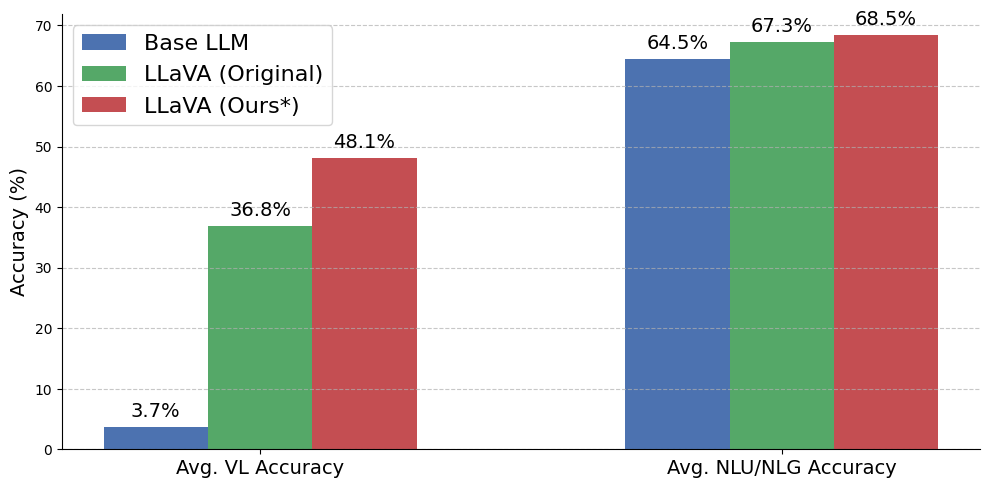

In [31]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the performance data
with open('results_A.json', 'r') as f:
    results = json.load(f)

with open('cl_performance.json', 'r') as f:
    cl_performance = json.load(f)

# Define the necessary datasets
datasets = [
    'vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa',
    'wsc273', 'winogrande', 'arc_easy', 'arc_challenge', 'mmlu'
]

# Map model names to labels
name_mapping = {
    'sgm': 'SGM',
    'msgm': 'mSGM',
    'vicuna': 'Vicuna 1.5 7B',
    'naive-ft': 'LLaVA Naive-FT'
}

# Function to extract average values
def extract_avg_values(model_name):
    tasks = cl_performance.get(model_name, {})
    task_3_perf = tasks.get('task_3_avg', {'VL': np.nan, 'NLU/NLG': np.nan})
    avg_vl_acc = task_3_perf['VL'] * 100
    avg_nlu_acc = task_3_perf['NLU/NLG'] * 100
    return avg_vl_acc, avg_nlu_acc

# Get data for Vicuna 1.5 7B from results_A.json
vicuna_metrics = results.get('reproduction-llava-v15+7b+stage-align+x7', {})
vicuna_vl_acc = np.mean([vicuna_metrics.get(dataset, np.nan) for dataset in ['vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa']]) * 100
vicuna_nlu_acc = np.mean([vicuna_metrics.get(dataset, np.nan) for dataset in ['wsc273', 'winogrande', 'arc_easy', 'arc_challenge', 'mmlu']]) * 100

# Get data for LLaVA Naive-FT
naive_ft_vl_acc, naive_ft_nlu_acc = extract_avg_values('naive-ft')

# Get data for SGM and mSGM, and determine the best
sgm_vl_acc, sgm_nlu_acc = extract_avg_values('sgm')
msgm_vl_acc, msgm_nlu_acc = extract_avg_values('msgm')

# Handle cases where the data might be NaN
if np.isnan(sgm_nlu_acc) or np.isnan(sgm_vl_acc):
    sgm_nlu_acc, sgm_vl_acc = 0, 0
if np.isnan(msgm_nlu_acc) or np.isnan(msgm_vl_acc):
    msgm_nlu_acc, msgm_vl_acc = 0, 0
if sgm_nlu_acc > msgm_nlu_acc:
    best_model = 'SGM'
    best_vl_acc = sgm_vl_acc
    best_nlu_acc = sgm_nlu_acc
else:
    best_model = 'mSGM'
    best_vl_acc = msgm_vl_acc
    best_nlu_acc = msgm_nlu_acc

# Handle cases where the data might be NaN for other models
vicuna_vl_acc = 0 if np.isnan(vicuna_vl_acc) else vicuna_vl_acc
vicuna_nlu_acc = 0 if np.isnan(vicuna_nlu_acc) else vicuna_nlu_acc
naive_ft_vl_acc = 0 if np.isnan(naive_ft_vl_acc) else naive_ft_vl_acc
naive_ft_nlu_acc = 0 if np.isnan(naive_ft_nlu_acc) else naive_ft_nlu_acc

# Data for plotting
labels = ['Avg. VL Accuracy', 'Avg. NLU/NLG Accuracy']
vicuna_values = [vicuna_vl_acc, vicuna_nlu_acc]
naive_ft_values = [naive_ft_vl_acc, naive_ft_nlu_acc]
best_values = [best_vl_acc, best_nlu_acc]
model_labels = ['Base LLM', 'LLaVA (Original)', f'LLaVA (Ours*)']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.2
x = np.arange(len(labels))

# Creating bars with appropriate colors
colors = ['#4c72b0', '#55a868', '#c44e52']
ax.bar(x - bar_width, vicuna_values, width=bar_width, label=model_labels[0], color=colors[0])
ax.bar(x, naive_ft_values, width=bar_width, label=model_labels[1], color=colors[1])
ax.bar(x + bar_width, best_values, width=bar_width, label=model_labels[2], color=colors[2])

# Adding labels and title
#ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_title('Average Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.legend(fontsize=16)

# Adding value labels on top of the bars
for i in range(len(labels)):
    if np.isfinite(vicuna_values[i]):
        ax.text(i - bar_width, vicuna_values[i] + 1, f'{vicuna_values[i]:.1f}%', ha='center', va='bottom', fontsize=14)
    if np.isfinite(naive_ft_values[i]):
        ax.text(i, naive_ft_values[i] + 1, f'{naive_ft_values[i]:.1f}%', ha='center', va='bottom', fontsize=14)
    if np.isfinite(best_values[i]):
        ax.text(i + bar_width, best_values[i] + 1, f'{best_values[i]:.1f}%', ha='center', va='bottom', fontsize=14)

# Remove spines and add gridlines for better readability
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('model_comparison_chart.png', format='png', dpi=300)
plt.show()
